<center><h1>Building a Visual Discovery app using Deep Video Analytics</h1></center>

<center><h2>Backend & Database</h2></center>

### Setup & import Django app

In [22]:
import sys
sys.path.append("../../")
import django,os,glob,base64
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "dva.settings")
django.setup()
from IPython.display import display,Image

In [14]:
import dvaapp.views as views
import dvaapp.tasks as tasks
from dvaapp.models import TEvent
from django.conf import settings

## Extraction and processing videos
You can monitor progress at https://localhost:8000/
Note that the following code executes each task in a synchronous manner, however when you submit videos through 
the web UI the tasks are executed in async manner using background celery workers. Further upon successful execution of each task the next task in processing pipeline is automatically created. 

In [4]:
video_list = [('vogue fashion',"https://www.youtube.com/watch?v=TJA6I-ZaoTY"),
              ('home decoration','https://www.youtube.com/watch?v=f0BkV6OV8z4')]
videos = {}
for name,url in video_list:
    # Create a video object
    v = views.handle_youtube_video(name,url)
    # Extract frames
    tasks.extract_frames(TEvent.objects.create(video=v).pk)
    # Perform inception
    tasks.inception_index_by_id(TEvent.objects.create(video=v).pk)
    # Perform SSD Detection
    tasks.perform_ssd_detection_by_id(TEvent.objects.create(video=v).pk)
    # Perform indexing on faces detected in the video
    tasks.perform_face_indexing(v.pk)
    # Index bounding boxeson all region
    tasks.inception_index_regions_by_id(TEvent.objects.create(video=v).pk)

## A simple query

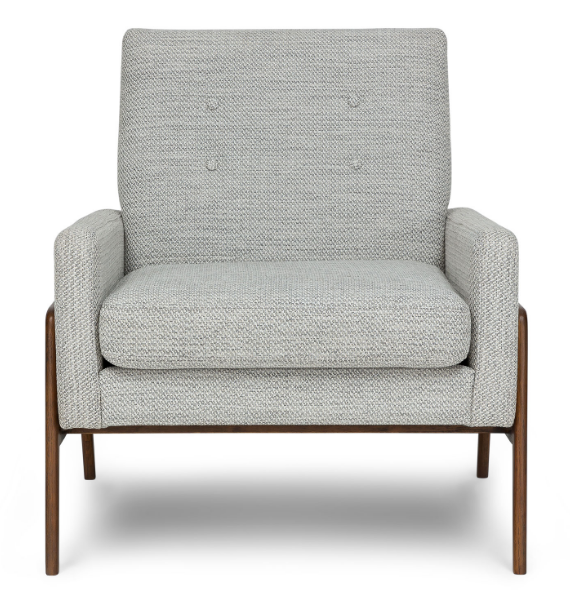

In [12]:
Image(filename='query_chair.png')

## Results

In [26]:
query,dv = views.create_query(20,False,['inception',],[],'data:image/png;base64,'+base64.encodestring(file('query_chair.png').read()))
results = tasks.inception_query_by_image(query.pk)

### Top 20 results

Detection


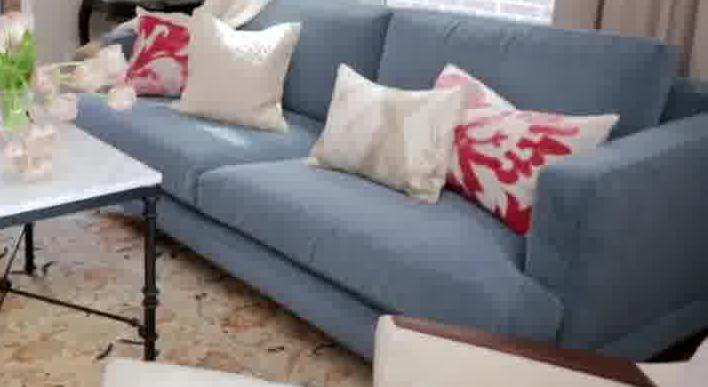

Detection


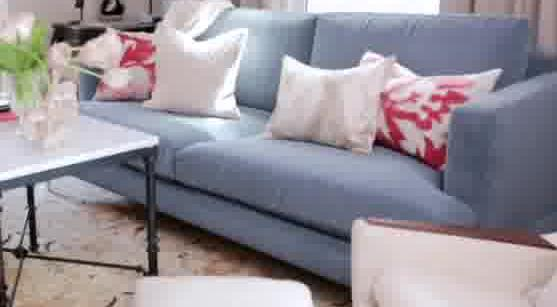

Detection


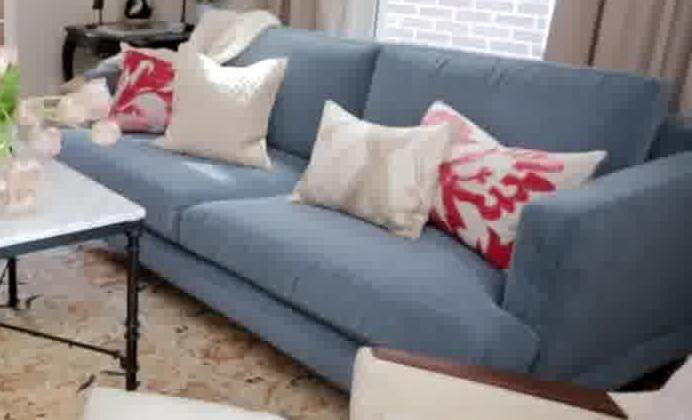

Detection


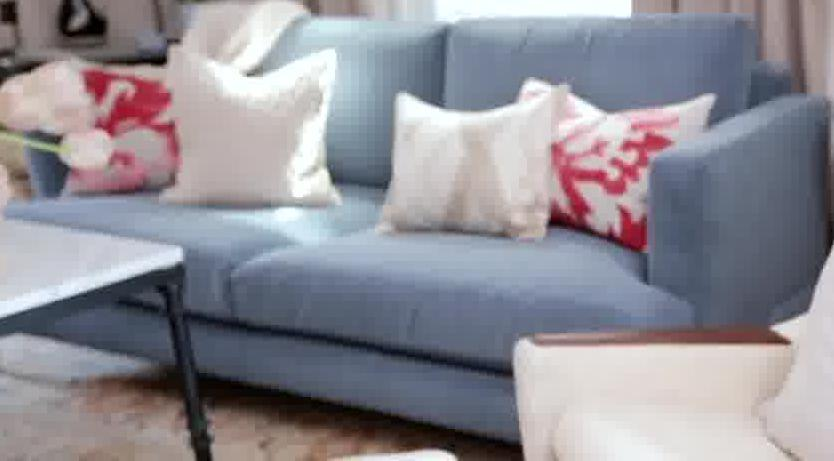

Detection


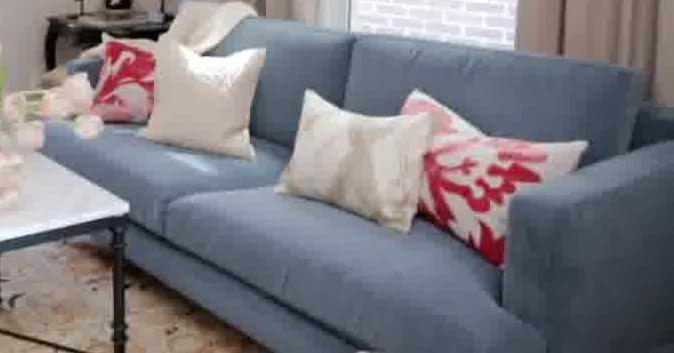

Detection


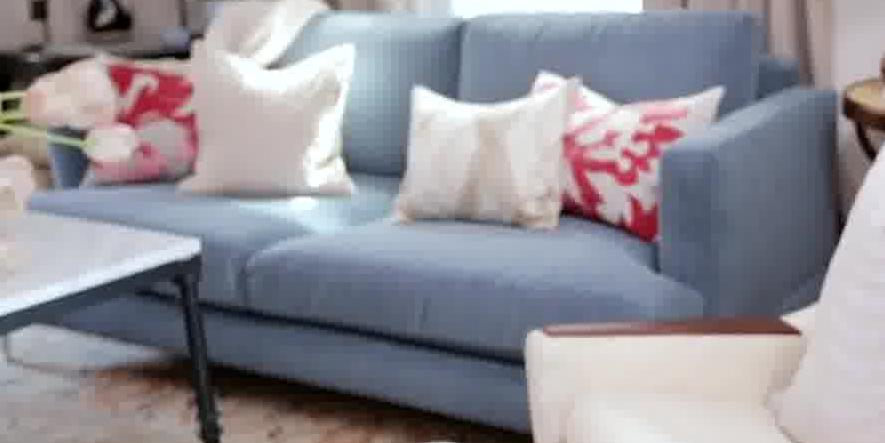

Frame


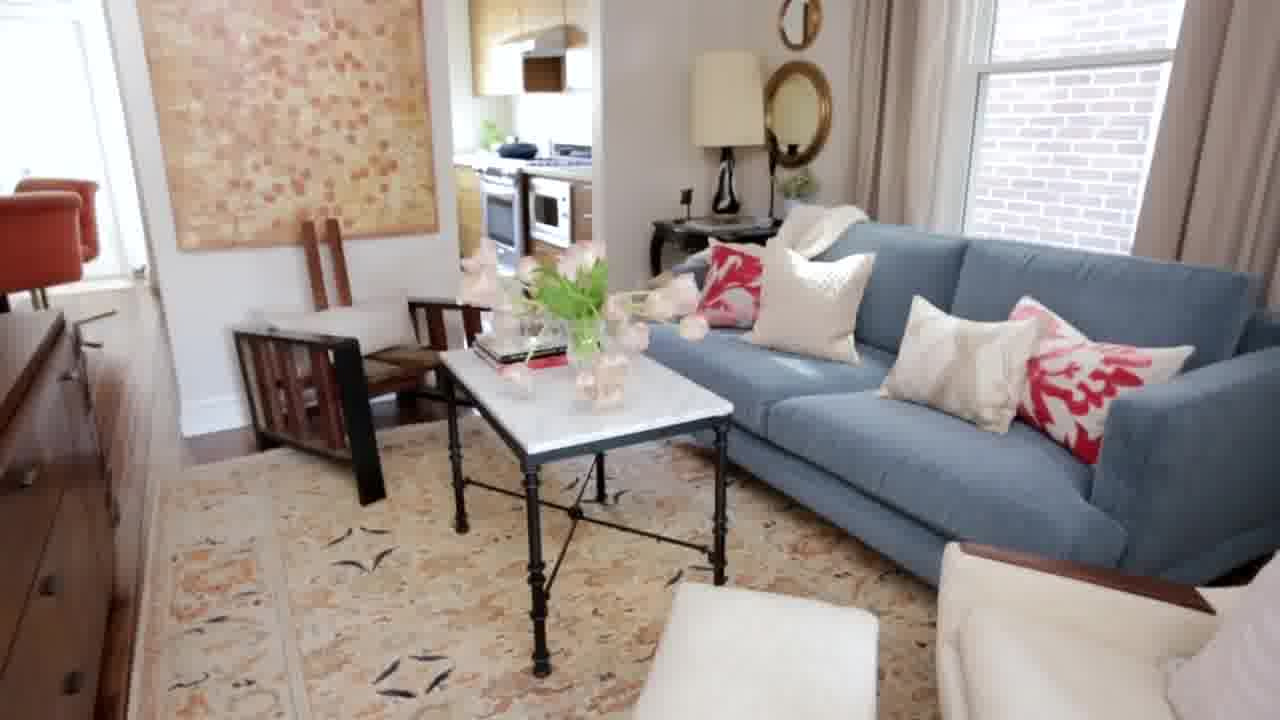

Detection


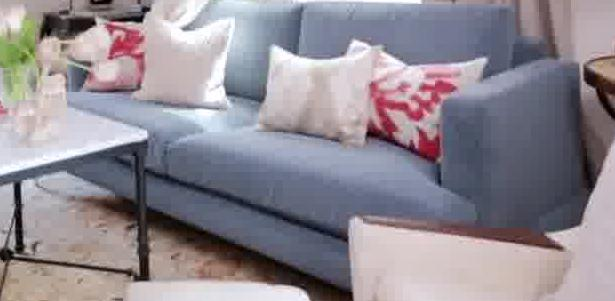

Detection


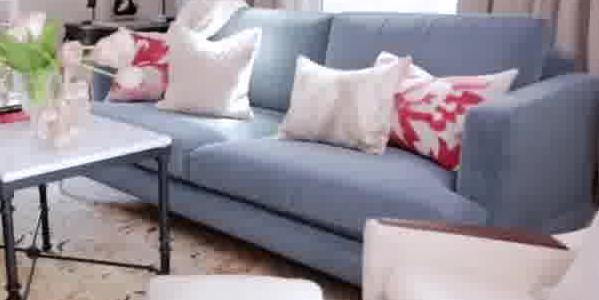

Detection


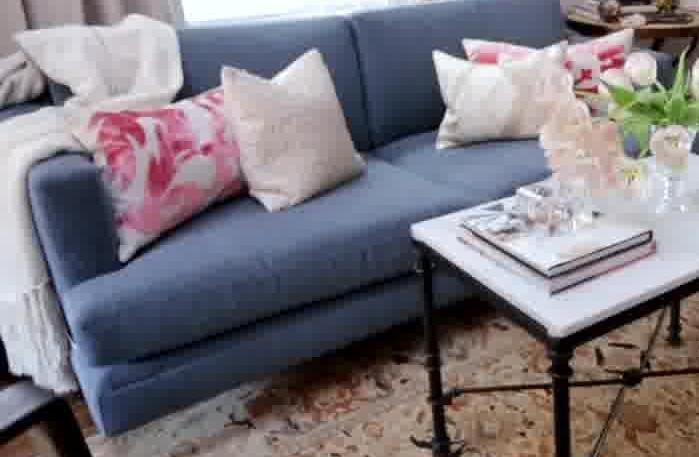

Frame


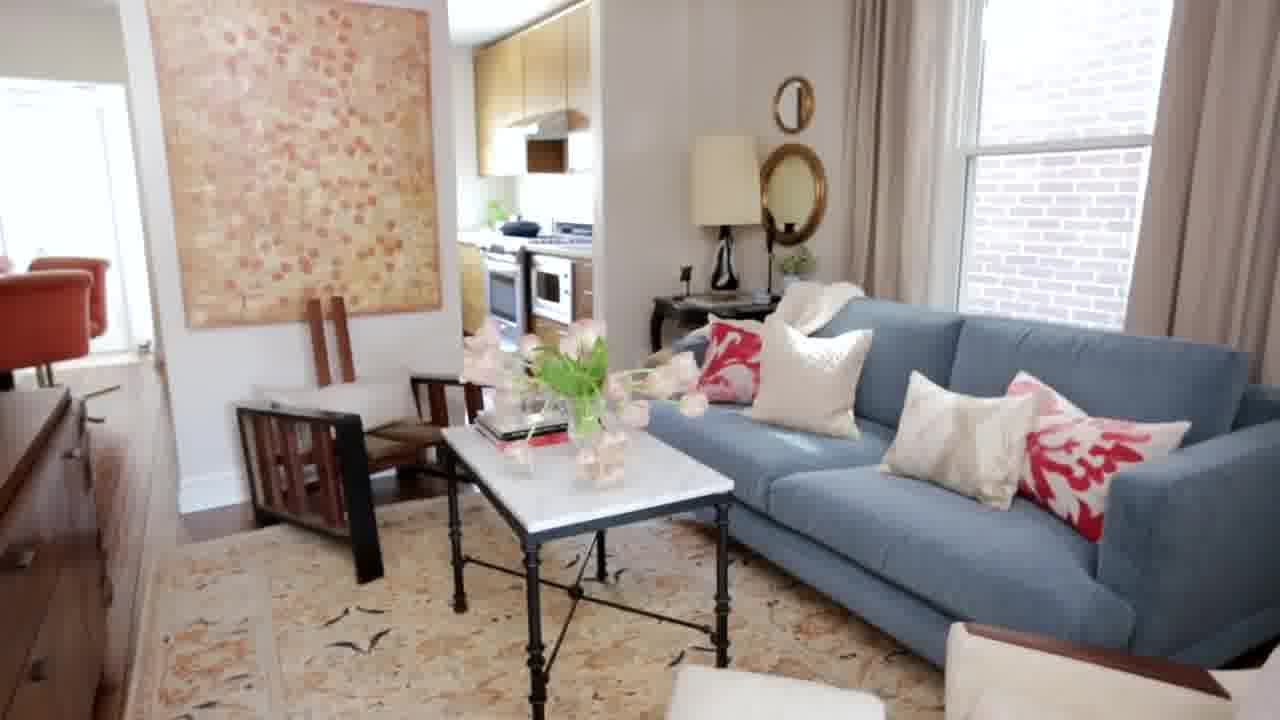

Detection


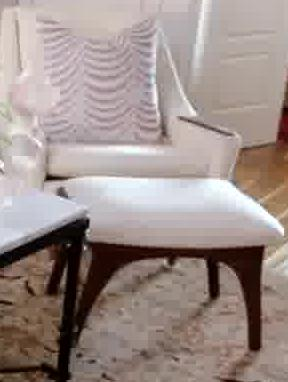

Detection


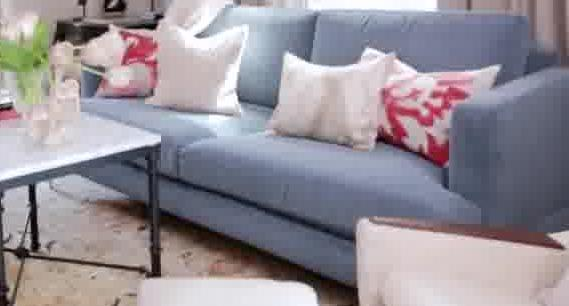

Detection


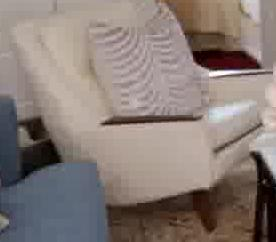

Frame


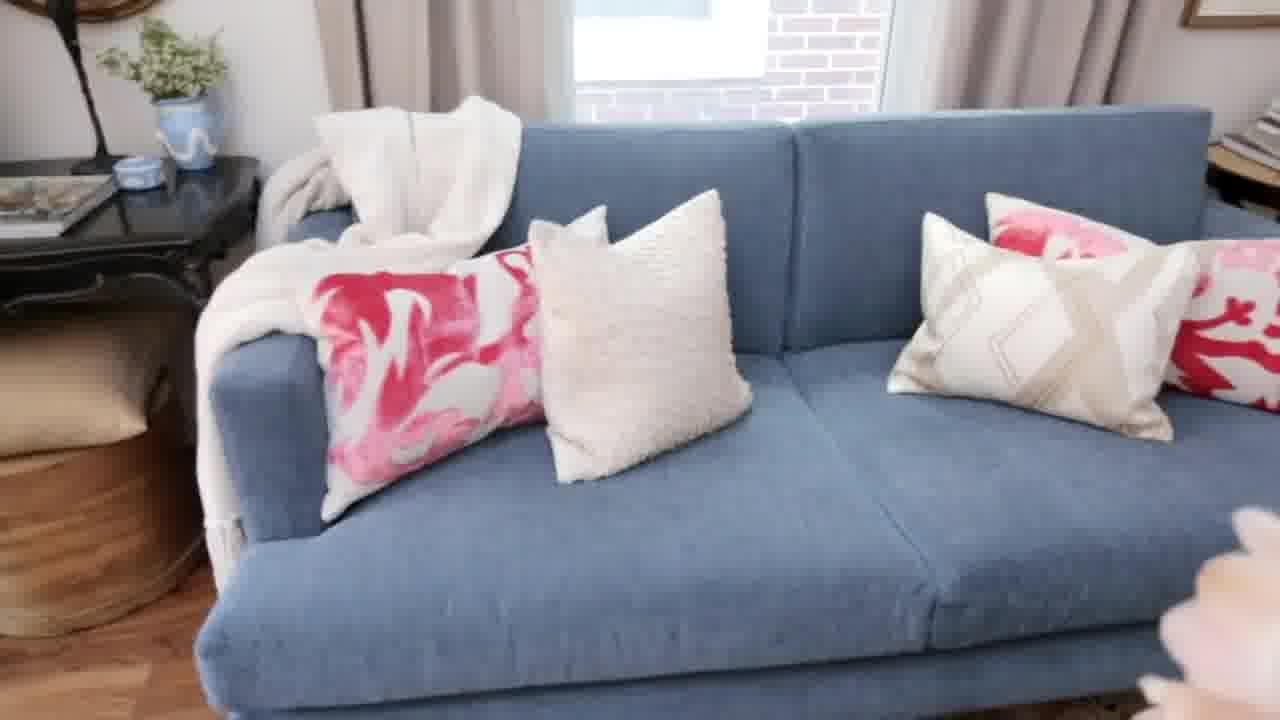

Frame


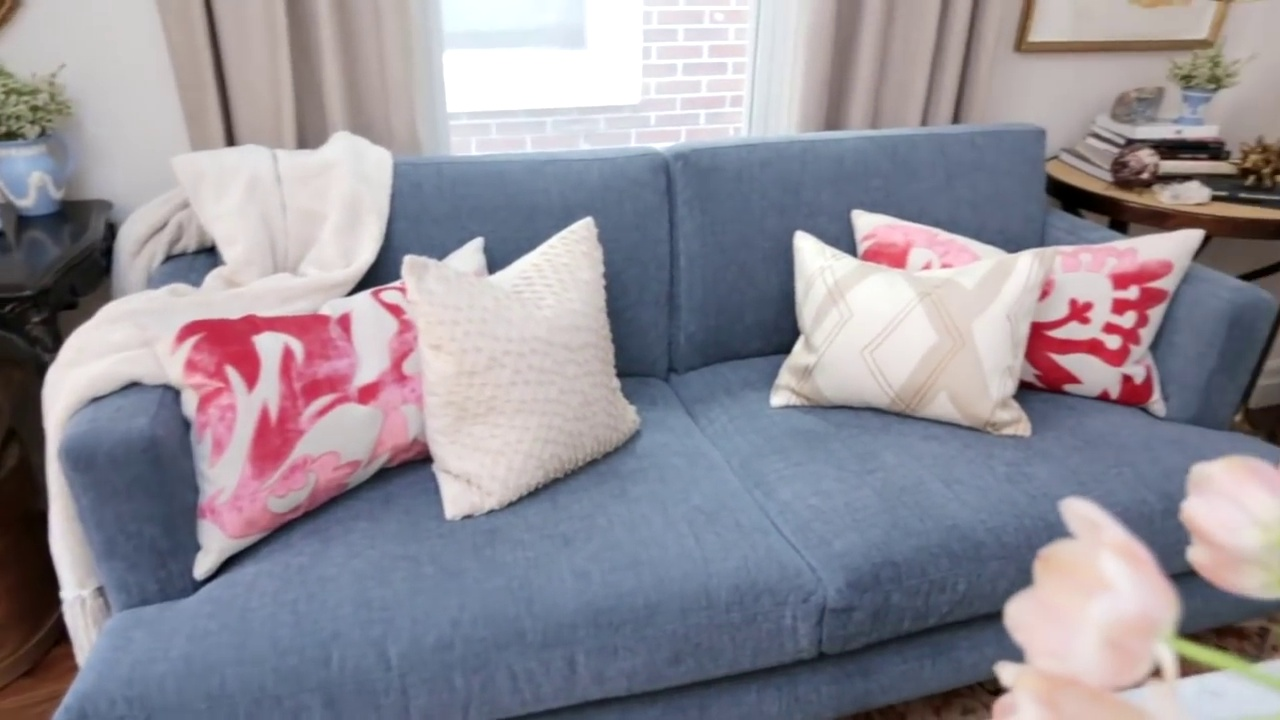

Detection


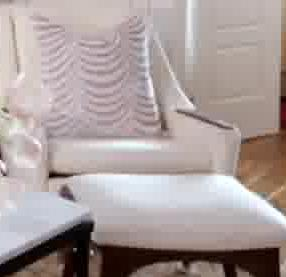

Detection


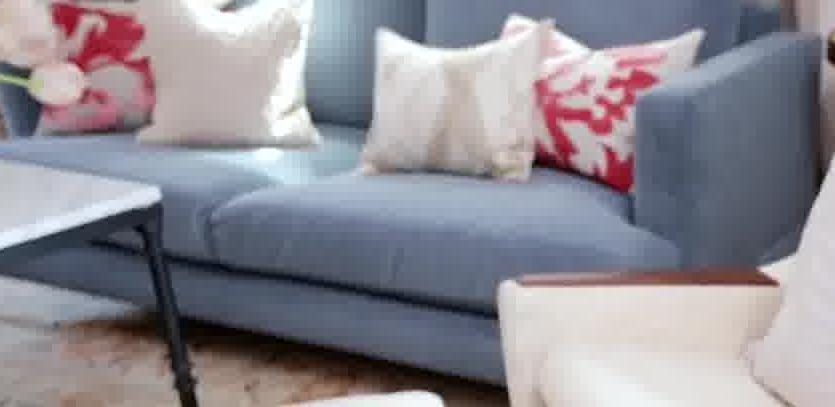

Frame


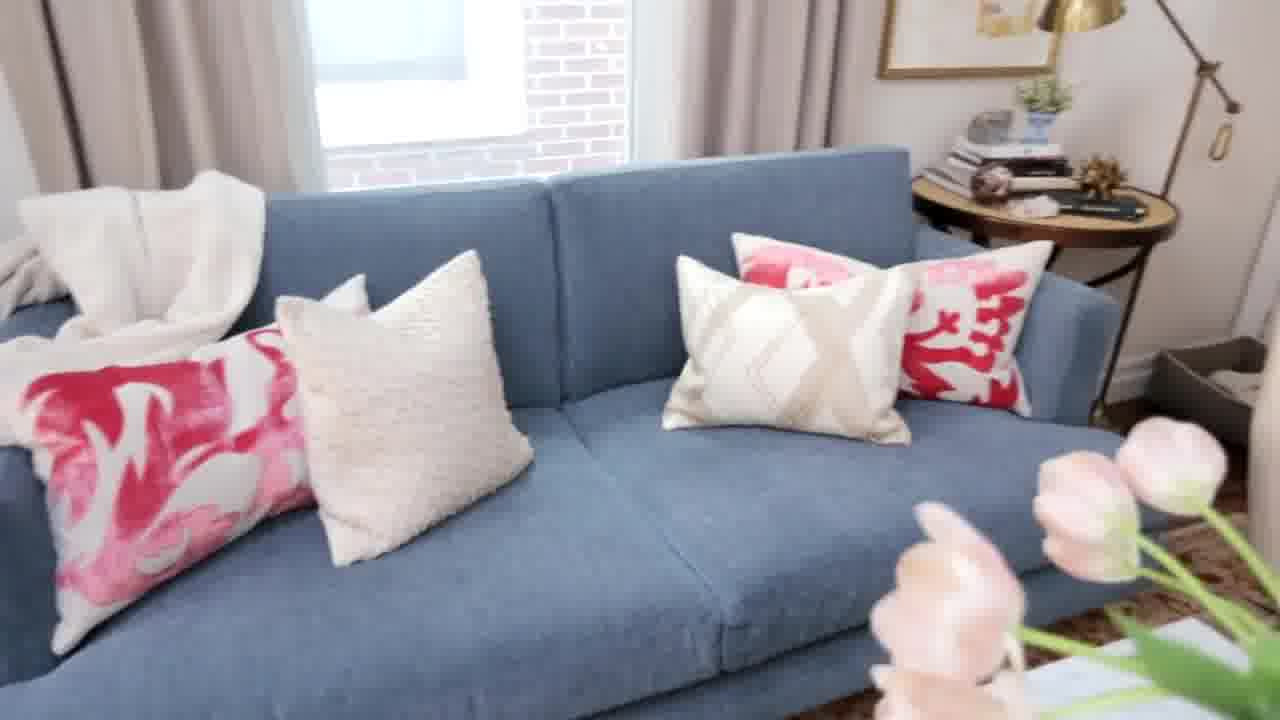

Detection


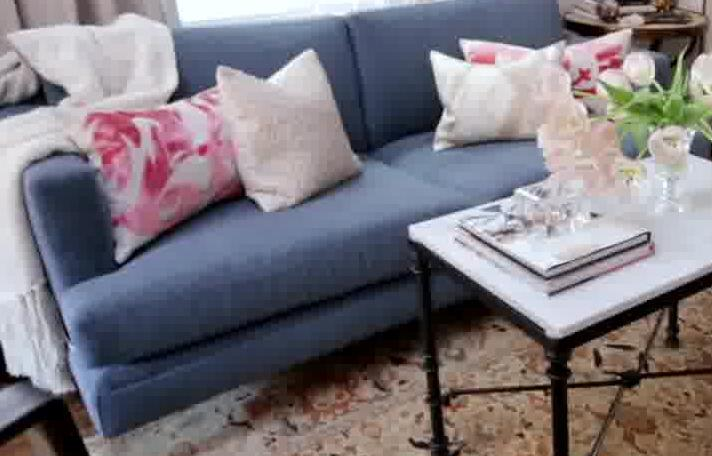

In [28]:
for k in results['inception'][:20]:
    if k[u'type'] == 'D' or k[u'type'] == 'A':
        print "Detection"
        display(Image(filename="{}/{}/detections/{}.jpg".format(settings.MEDIA_ROOT,k[u'video_primary_key'],k[u'detection_primary_key'])))
    else:
        print "Frame"
        display(Image(filename="{}/{}/frames/{}.jpg".format(settings.MEDIA_ROOT,k[u'video_primary_key'],k[u'frame_index'])))